In [2]:
!python -V

Python 3.9.13


In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import *
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [4]:
# Importing the data
jan_data = pd.read_parquet('./data/yellow_tripdata_2022-01.parquet')
feb_data = pd.read_parquet('./data/yellow_tripdata_2022-02.parquet')

In [5]:
jan_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [6]:
jan_data['trip_duration'] = jan_data.tpep_dropoff_datetime - jan_data.tpep_pickup_datetime
jan_data.trip_duration = jan_data.trip_duration.apply(lambda td: td.total_seconds() / 60)
print(f"The standard deviation for trip duration is {jan_data.trip_duration.std()}")

The standard deviation for trip duration is 46.44530513776802


In [7]:
filtered_data = jan_data[(jan_data['trip_duration'] >= 1) & (jan_data['trip_duration'] <= 60)]
num_records = len(filtered_data)
percentage = (num_records / len(jan_data)) * 100
print(f"Percentage of records within the duration range: {percentage:.2f}%")

Percentage of records within the duration range: 98.28%


In [8]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
jan_data[categorical] = jan_data[categorical].astype(str)
train_dicts = jan_data[categorical + numerical].to_dict(orient='records')

In [9]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'trip_duration'
y_train = jan_data[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

num_rows, num_cols = X_train.shape
print(f"Dimensionality of the feature matrix: {num_rows}, {num_cols}")

Dimensionality of the feature matrix: 2463931, 519


In [10]:
mse = mean_squared_error(y_train, y_pred, squared=False)
print("The Mean Squared Error for the model is:", mse)

The Mean Squared Error for the model is: 46.03273135453733


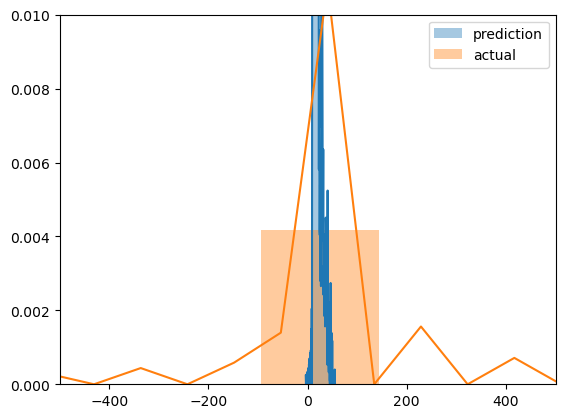

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.xlim(-500, 500)
plt.ylim(0,0.01)
plt.legend()

In [12]:
df_train = read_df('./data/yellow_tripdata_2022-01.parquet')
df_val = read_df('./data/yellow_tripdata_2022-02.parquet')

In [13]:
len(df_train), len(df_val)

(2421440, 2918187)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"The RMSE on train is {rmse}")

The RMSE on train is 4.797275624646443


In [18]:
y_val_pred = lr.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"The RMSE on validation is {rmse}")

The RMSE on validation is 5.530377152517906


In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
## Modeling with Lasso
ls = Lasso()
ls.fit(X_train, y_train)
y_train_pred = ls.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"The RMSE on training is {rmse}")

The RMSE on training is 8.999061373050163


In [21]:
y_val_pred = ls.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared = False)
print(f"The RMSE on validation is {rmse}")

The RMSE on validation is 9.708000985372925


In [22]:
with open('models/las_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [23]:
## Modeling with Ridge
rg = Ridge()
rg.fit(X_train, y_train)
y_train_pred = rg.predict(X_train)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"The RMSE on training is {rmse}")

The RMSE on training is 4.6425074394898065


In [24]:
y_val_pred = rg.predict(X_val)
rmse = mean_squared_error(y_val, y_val_pred, squared = False)
print(f"The RMSE on validation is {rmse}")

The RMSE on validation is 5.436610194083894


In [25]:
with open('models/rid_reg.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)